In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install prometheus-eval
!pip install flash-attn --no-build-isolation
!pip install vllm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-m

In [ ]:
!python -c "import prometheus_eval; print(prometheus_eval.__version__)"

0.1.15


Step 1: Load the Fine-Tuned LLM Responses

In [ ]:
import pandas as pd

# Load the fine-tuned LLM responses from the CSV file
finetuned_path = '/content/drive/MyDrive/1-Working/1-HSLU-MscIDS/5-Projects/4-Semester/CLT/Samuel-CLT-Development/Finetuned-Phi3-Answers.csv'
finetuned_responses = pd.read_csv(finetuned_path)

print(finetuned_responses.shape)

# Display the first few rows to verify the data
finetuned_responses.head()


(12, 2)


,Question,Finetuned-Phi3-Answers
0,What components make up the emergency power su...,What components make up the emergency power su...
1,How does the adjustable height feature of the ...,How does the adjustable height feature of the ...
2,How does the BP neural network-based composite...,How does the BP neural network-based composite...
3,What is the primary function of the excitation...,What is the primary function of the excitation...
4,How does the real-time monitoring device enhan...,How does the real-time monitoring device enhan...


Clean the finetuned answer as they contain the question as well.

In [ ]:
# Function to clean the Finetuned-Phi3-Answers column by removing the question part
def clean_answers(row):
    question, answer = row.split('?', 1)
    return answer.strip()

# Apply the function to the Finetuned-Phi3-Answers column
finetuned_responses['Finetuned-Phi3-Answers'] = finetuned_responses['Finetuned-Phi3-Answers'].apply(clean_answers)

print(finetuned_responses.shape)

# Display the cleaned DataFrame
finetuned_responses


,Question,Finetuned-Phi3-Answers
0,What components make up the emergency power su...,The emergency power supply function of the FTU...
1,How does the adjustable height feature of the ...,The energy-saving intelligent street lamp with...
2,How does the BP neural network-based composite...,The BP neural network-based composite heating ...
3,What is the primary function of the excitation...,The primary function of the excitation-enhance...
4,How does the real-time monitoring device enhan...,The real-time monitoring device significantly ...
5,What are the key components and design feature...,The adjustable airflow ventilation system is d...
6,How much did the U.S. rig count increase in th...,The U.S. rig count increased by 10 units to 70...
7,What is the expected annual reduction in CO2 e...,The planned 20-kilometer geothermal heat netwo...
8,What was the percentage decrease in the Februa...,The February Nymex gas futures contract fell 1...
9,How does the Auxiliary Sail Propulsion System ...,The Auxiliary Sail Propulsion System (ASPS) is...


Step 2: Define the Baseline and GROQ Responses

In [ ]:
import pandas as pd

# Define baseline and GROQ responses
data = {
    'Question': [
        # Patent QA Pairs
        "What components make up the emergency power supply function of the FTU?",
        "How does the adjustable height feature of the energy-saving intelligent street lamp work?",
        "How does the BP neural network-based composite heating control system achieve energy efficiency?",
        "What is the primary function of the excitation-enhanced ocean current energy generating system?",
        "How does the real-time monitoring device enhance safety in the nuclear power plant control system?",
        "What are the key components and design features of the adjustable airflow ventilation system?",
        # Media QA Pairs
        "How much did the U.S. rig count increase in the week ended April 29 compared to the same period last year?",
        "What is the expected annual reduction in CO2 emissions from the planned 20-kilometer geothermal heat network in Pantin, Les Lilas, and Pré-Saint-Gervais, and which types of buildings will benefit from this initiative?",
        "What was the percentage decrease in the February Nymex gas futures contract from the previous day's close, and how did the actual withdrawal of natural gas from storage for the final week of 2021 compare to expectations?",
        "How does the Auxiliary Sail Propulsion System (ASPS) utilize fixed wing sail technology and the rotation of masts to harness wind power for propulsion?",
        "What was the total amount of new energy storage systems brought online in Q4 2020 in the U.S., and which state had the majority of these deployments?",
        "What was the total amount of new funds raised by startups in the first half of 2022?"
    ],
    'Baseline Answer': [
        # Patent Baseline Answers
        "The invention provides an FTU with an emergency power supply function, which includes an integrated battery system, a control unit for power management, and a mechanism for automatic switching between the main power and the emergency supply.",
        "The utility model discloses an energy-saving intelligent street lamp with an adjustable height mechanism, which allows the lamp to be raised or lowered based on environmental conditions or specific needs, improving light coverage and energy usage efficiency.",
        "The invention provides a composite heating control system that uses a BP neural network to optimize heating schedules and power usage, significantly enhancing energy efficiency by adapting to real-time environmental changes and usage patterns.",
        "The invention discloses an excitation-enhanced ocean current energy generating system designed to increase the efficiency of energy extraction from ocean currents using advanced turbine technologies.",
        "The device can monitor the operation and maintenance of critical components in real-time, using sensors and data analytics to predict potential failures and automatically initiate safety protocols, thereby significantly enhancing the overall safety of the nuclear power plant.",
        "Embodiments of the present disclosure provide an adjustable airflow ventilation system that includes motorized air vents, a central control unit that adjusts airflow based on air quality sensors, and a feedback loop to maintain optimal indoor air conditions.",
        # Media Baseline Answers
        "The U.S. rig count rose three units to 698 for the week ended Friday (April 29), according to the latest figures from oilfield services provider Baker Hughes Co. The 698 active rigs as of Friday compares with 440 rigs running in the same period last year.",
        "A 20-kilometer geothermal heat network is planned to be deployed in the communes of Pantin, Les Lilas, and Pré-Saint-Gervais in Paris between 2024 and 2026. This will supply heating and hot water to condominiums, social housing, and public facilities and will save about 28,000 tons of CO2 emissions per year.",
        "The February Nymex gas futures contract fell 7.0 cents day/day and settled at $3.812/MMBtu. The U.S. Energy Information Administration on Thursday reported a withdrawal of 31 Bcf natural gas from storage for the final week of 2021. The result missed expectations by a wide margin.",
        "The Auxiliary Sail Propulsion System (ASPS) uses fixed wing sail technology. Two 35-metre high masts installed on the deck of a vessel will each have three aerodynamic wings fitted. The masts or rigs rotate automatically to exploit the power of the prevailing wind.",
        "There was a total of 2,156 MWh of new energy storage systems brought online in Q4 2020. This was an increase of 182% from Q3 2020, making Q4 the new record quarter for U.S. storage. California touted a majority of Q4 FTM deployments.",
        "Total investment in European solar startups surged by nearly 400% year on year in the January-May period. Companies secured $6 billion of new funds, from just $1.2 billion raised during the same period in 2022."
    ],
    'GROQ Answer': [
        # Patent GROQ Answers
        "The FTU (Frascati Tokamak Upgrade) is a tokamak device used for plasma physics research. The emergency power supply function of the FTU is designed to provide backup power to the device in case of a primary power failure. The components that make up the emergency power supply function of the FTU include: Uninterruptible Power Supply (UPS).",
        "The adjustable height feature of the energy-saving intelligent street lamp is an innovative technology that allows the lamp to adjust its height in response to changing environmental conditions. Here's how it works: Sensors and Algorithms, Height Adjustment Mechanism.",
        "The BP (Backpropagation) neural network-based composite heating control system achieves energy efficiency in several ways: Optimized temperature control, Predictive maintenance.",
        "I apologize, but there is no such thing as an 'excitation-enhanced ocean current energy generating system.' It appears to be a fictional or hypothetical concept.",
        "Real-time monitoring devices play a crucial role in enhancing safety in nuclear power plant control systems by providing continuous and accurate monitoring of plant operations, allowing for swift detection and response to potential safety issues.",
        "The adjustable airflow ventilation system is a type of ventilation system that allows for the adjustment of airflow rates and directions to optimize indoor air quality and thermal comfort. The key components and design features of such a system typically include: Air Handling Unit (AHU), Fan.",
        # Media GROQ Answers
        "According to the Baker Hughes rig count, the U.S. rig count increased by 10 rigs in the week ended April 29, compared to the same period last year.",
        "According to the City of Paris's website, the planned 20-kilometer geothermal heat network in Pantin, Les Lilas, and Pré-Saint-Gervais is expected to reduce CO2 emissions by approximately 12,000 tons per year.",
        "According to the data from the Energy Information Administration (EIA), the February Nymex gas futures contract decreased by 2.4% from the previous day's close on January 12, 2022.",
        "I apologize, but there is no such thing as the 'Auxiliary Sail Propulsion System (ASPS)' that utilizes fixed wing sail technology and the rotation of masts to harness wind power for propulsion.",
        "According to the Energy Storage Association's (ESA) Q4 2020 Energy Storage Monitor, a total of 1,144 MWh of new energy storage systems were brought online in the United States during the fourth quarter of 2020.",
        "According to a report by CB Insights, a leading venture capital research firm, the total amount of new funds raised by startups in the first half of 2022 was approximately $143.4 billion."
    ]
}


# Create DataFrame for baseline and GROQ responses
comparison_df = pd.DataFrame(data)

print(comparison_df.shape)
comparison_df


(12, 3)


,Question,Baseline Answer,GROQ Answer
0,What components make up the emergency power su...,The invention provides an FTU with an emergenc...,The FTU (Frascati Tokamak Upgrade) is a tokama...
1,How does the adjustable height feature of the ...,The utility model discloses an energy-saving i...,The adjustable height feature of the energy-sa...
2,How does the BP neural network-based composite...,The invention provides a composite heating con...,The BP (Backpropagation) neural network-based ...
3,What is the primary function of the excitation...,The invention discloses an excitation-enhanced...,"I apologize, but there is no such thing as an ..."
4,How does the real-time monitoring device enhan...,The device can monitor the operation and maint...,Real-time monitoring devices play a crucial ro...
5,What are the key components and design feature...,Embodiments of the present disclosure provide ...,The adjustable airflow ventilation system is a...
6,How much did the U.S. rig count increase in th...,The U.S. rig count rose three units to 698 for...,"According to the Baker Hughes rig count, the U..."
7,What is the expected annual reduction in CO2 e...,A 20-kilometer geothermal heat network is plan...,"According to the City of Paris's website, the ..."
8,What was the percentage decrease in the Februa...,The February Nymex gas futures contract fell 7...,According to the data from the Energy Informat...
9,How does the Auxiliary Sail Propulsion System ...,The Auxiliary Sail Propulsion System (ASPS) us...,"I apologize, but there is no such thing as the..."


Step 3: Combine dataframes

In [ ]:
# Ensure the DataFrame for fine-tuned responses only contains the filtered rows
filtered_finetuned_responses = finetuned_responses[finetuned_responses['Question'].isin(data['Question'])]

# Add the fine-tuned answers to the comparison DataFrame
comparison_df['Finetuned-Phi3-Answers'] = filtered_finetuned_responses['Finetuned-Phi3-Answers'].values

print(comparison_df.shape)
# Display the combined DataFrame for review
comparison_df


(12, 4)


,Question,Baseline Answer,GROQ Answer,Finetuned-Phi3-Answers
0,What components make up the emergency power su...,The invention provides an FTU with an emergenc...,The FTU (Frascati Tokamak Upgrade) is a tokama...,The emergency power supply function of the FTU...
1,How does the adjustable height feature of the ...,The utility model discloses an energy-saving i...,The adjustable height feature of the energy-sa...,The energy-saving intelligent street lamp with...
2,How does the BP neural network-based composite...,The invention provides a composite heating con...,The BP (Backpropagation) neural network-based ...,The BP neural network-based composite heating ...
3,What is the primary function of the excitation...,The invention discloses an excitation-enhanced...,"I apologize, but there is no such thing as an ...",The primary function of the excitation-enhance...
4,How does the real-time monitoring device enhan...,The device can monitor the operation and maint...,Real-time monitoring devices play a crucial ro...,The real-time monitoring device significantly ...
5,What are the key components and design feature...,Embodiments of the present disclosure provide ...,The adjustable airflow ventilation system is a...,The adjustable airflow ventilation system is d...
6,How much did the U.S. rig count increase in th...,The U.S. rig count rose three units to 698 for...,"According to the Baker Hughes rig count, the U...",The U.S. rig count increased by 10 units to 70...
7,What is the expected annual reduction in CO2 e...,A 20-kilometer geothermal heat network is plan...,"According to the City of Paris's website, the ...",The planned 20-kilometer geothermal heat netwo...
8,What was the percentage decrease in the Februa...,The February Nymex gas futures contract fell 7...,According to the data from the Energy Informat...,The February Nymex gas futures contract fell 1...
9,How does the Auxiliary Sail Propulsion System ...,The Auxiliary Sail Propulsion System (ASPS) us...,"I apologize, but there is no such thing as the...",The Auxiliary Sail Propulsion System (ASPS) is...


Step 1: Define the Rubric for Evaluation (https://github.com/prometheus-eval/prometheus-eval/tree/main)

In [ ]:
from prometheus_eval.vllm import VLLM
from prometheus_eval import PrometheusEval
from prometheus_eval.prompts import ABSOLUTE_PROMPT, SCORE_RUBRIC_TEMPLATE

model = VLLM(model="prometheus-eval/prometheus-7b-v2.0", max_model_len=12000)
judge = PrometheusEval(model=model, absolute_grade_template=ABSOLUTE_PROMPT)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

INFO 06-07 07:52:54 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='prometheus-eval/prometheus-7b-v2.0', speculative_config=None, tokenizer='prometheus-eval/prometheus-7b-v2.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=12000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=prometheus-eval/prometheus-7b-v2.0)


tokenizer_config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

INFO 06-07 07:53:00 weight_utils.py:207] Using model weights format ['*.safetensors']


model-00004-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/789M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

INFO 06-07 07:53:53 model_runner.py:146] Loading model weights took 13.4966 GB
INFO 06-07 07:53:57 gpu_executor.py:83] # GPU blocks: 2455, # CPU blocks: 2048
INFO 06-07 07:54:00 model_runner.py:854] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-07 07:54:00 model_runner.py:858] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-07 07:54:07 model_runner.py:924] Graph capturing finished in 8 secs.


/usr/local/lib/python3.10/dist-packages/prometheus_eval/judge.py:50: UserWarning: Reference answer was not given in Relative Grading mode. This might lead to non-optimal performances.
  warnings.warn(


In [ ]:
rubric_data = {
  "criteria": "Is the model proficient in providing accurate, relevant, detailed, and fact-based technical responses to cleantech-related questions, compared to the baseline (ground truth) answers?",
  "score1_description": "The response is inaccurate and provides incorrect or misleading information compared to the baseline. The response is irrelevant to the question asked. The response lacks technical detail and specificity. The response lacks factual data and figures, or provides incorrect data. The response deviates significantly from the baseline (ground truth).",
  "score2_description": "The response is partially accurate but includes significant errors compared to the baseline. The response is only partially relevant to the question. The response includes some technical details but is generally superficial. The response includes limited factual data and figures, with some inaccuracies. The response shows poor alignment with the baseline (ground truth).",
  "score3_description": "The response is generally accurate but may have minor errors compared to the baseline. The response is relevant to the question asked. The response includes adequate technical detail but lacks depth. The response includes factual data and figures but may lack precision. The response shows moderate alignment with the baseline (ground truth).",
  "score4_description": "The response is mostly accurate with minor errors compared to the baseline. The response is mostly relevant to the question and covers key aspects. The response includes detailed technical information with minor gaps. The response includes accurate factual data and figures. The response shows good alignment with the baseline (ground truth).",
  "score5_description": "The response is highly accurate and free from errors compared to the baseline. The response is highly relevant and comprehensively addresses the question. The response includes thorough and detailed technical information. The response includes precise and accurate factual data and figures. The response shows excellent alignment with the baseline (ground truth)."
}

score_rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data)

In [ ]:
score_rubric

'[Is the model proficient in providing accurate, relevant, detailed, and fact-based technical responses to cleantech-related questions, compared to the baseline (ground truth) answers?]\nScore 1: The response is inaccurate and provides incorrect or misleading information compared to the baseline. The response is irrelevant to the question asked. The response lacks technical detail and specificity. The response lacks factual data and figures, or provides incorrect data. The response deviates significantly from the baseline (ground truth).\nScore 2: The response is partially accurate but includes significant errors compared to the baseline. The response is only partially relevant to the question. The response includes some technical details but is generally superficial. The response includes limited factual data and figures, with some inaccuracies. The response shows poor alignment with the baseline (ground truth).\nScore 3: The response is generally accurate but may have minor errors co

FINETUNE EVAL

In [ ]:
# Extract instructions, responses, and reference answers for Fine-Tuned LLM
instructions = comparison_df['Question'].tolist()
responses_finetuned = comparison_df['Finetuned-Phi3-Answers'].tolist()
reference_answers = comparison_df['Baseline Answer'].tolist()


In [ ]:
instructions

['What components make up the emergency power supply function of the FTU?',
 'How does the adjustable height feature of the energy-saving intelligent street lamp work?',
 'How does the BP neural network-based composite heating control system achieve energy efficiency?',
 'What is the primary function of the excitation-enhanced ocean current energy generating system?',
 'How does the real-time monitoring device enhance safety in the nuclear power plant control system?',
 'What are the key components and design features of the adjustable airflow ventilation system?',
 'How much did the U.S. rig count increase in the week ended April 29 compared to the same period last year?',
 'What is the expected annual reduction in CO2 emissions from the planned 20-kilometer geothermal heat network in Pantin, Les Lilas, and Pré-Saint-Gervais, and which types of buildings will benefit from this initiative?',
 "What was the percentage decrease in the February Nymex gas futures contract from the previous

In [ ]:
responses_finetuned

['The emergency power supply function of the FTU comprises the following components:\n\n1. The emergency power supply is connected to the FTU through a power supply cable.\n2. The FTU is equipped with a power supply module, which is responsible for converting the emergency power supply into usable power for the FTU.\n3. The FTU also includes a power management module, which regulates and distributes the power generated by the power supply module.\n4. The FTU is further equipped with a power storage module, which stores excess power generated by the power supply module for later use.\n5. The FTU is connected to the power grid through a power grid connection module, allowing it to draw power from the grid when necessary.\n6. The FTU is also equipped with a power monitoring module, which monitors the power consumption and generation of the FTU.\n7. The FTU includes a power protection module, which safeguards the FTU from power fluctuations and ensures a stable power supply.\n8. The FTU is

In [ ]:
reference_answers

['The invention provides an FTU with an emergency power supply function, which includes an integrated battery system, a control unit for power management, and a mechanism for automatic switching between the main power and the emergency supply.',
 'The utility model discloses an energy-saving intelligent street lamp with an adjustable height mechanism, which allows the lamp to be raised or lowered based on environmental conditions or specific needs, improving light coverage and energy usage efficiency.',
 'The invention provides a composite heating control system that uses a BP neural network to optimize heating schedules and power usage, significantly enhancing energy efficiency by adapting to real-time environmental changes and usage patterns.',
 'The invention discloses an excitation-enhanced ocean current energy generating system designed to increase the efficiency of energy extraction from ocean currents using advanced turbine technologies.',
 'The device can monitor the operation 

In [ ]:
# Perform batch grading for Fine-Tuned LLM
feedbacks_finetuned, scores_finetuned = judge.absolute_grade(
    instructions=instructions,
    responses=responses_finetuned,
    rubric=score_rubric,
    reference_answers=reference_answers
)

# Display feedback and scores
for i, (feedback, score) in enumerate(zip(feedbacks_finetuned, scores_finetuned)):
    print(f"Question {i+1}:")
    print(f"Feedback: {feedback}")
    print(f"Score: {score}")
    print()

Processed prompts: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it, Generation Speed: 111.94 toks/s]


Processed 12/12 instances.


Finalizing: 100%|██████████| 12/12 [00:00<00:00, 91015.64it/s]

Question 1:
Feedback: The provided response is inaccurate, presenting a disjointed list of components without a coherent explanation of how these components contribute to the emergency power supply function of the FTU. The response lacks relevant information and fails to provide any factual data or figures that would substantiate the claims made. The mention of a "power supply cable" and a "power supply module" is vague and does not contribute to a clear understanding of the emergency power supply function. Additionally, the inclusion of modules such as a "power protection module" and a "power control module" is not aligned with the expected emergency power supply components. Therefore, the response deviates significantly from the expected accurate, relevant, and detailed technical information, and is largely factually incorrect. The model shows poor proficiency in providing the requested technical responses to the question asked.
Score: 1

Question 2:
Feedback: The response provides a

In [ ]:
feedbacks_finetuned

['The provided response is inaccurate, presenting a disjointed list of components without a coherent explanation of how these components contribute to the emergency power supply function of the FTU. The response lacks relevant information and fails to provide any factual data or figures that would substantiate the claims made. The mention of a "power supply cable" and a "power supply module" is vague and does not contribute to a clear understanding of the emergency power supply function. Additionally, the inclusion of modules such as a "power protection module" and a "power control module" is not aligned with the expected emergency power supply components. Therefore, the response deviates significantly from the expected accurate, relevant, and detailed technical information, and is largely factually incorrect. The model shows poor proficiency in providing the requested technical responses to the question asked.',
 "The response provides a good explanation of how the adjustable height f

In [ ]:
scores_finetuned

[1, 3, 3, 4, 4, 3, 1, 2, 4, 3, 4, 5]

Extract Scores into a DataFrame for Fine-Tuned LLM

In [ ]:
# Create a DataFrame to store the scores for Fine-Tuned LLM
scores_finetuned_df = pd.DataFrame({
    'Question Number': range(1, len(scores_finetuned) + 1),
    'Score': scores_finetuned
})

# Display the DataFrame
scores_finetuned_df





,Question Number,Score
0,1,1
1,2,3
2,3,3
3,4,4
4,5,4
5,6,3
6,7,1
7,8,2
8,9,4
9,10,3


In [ ]:
# Calculate and display the average score for Fine-Tuned LLM
average_score_finetuned = scores_finetuned_df['Score'].mean()
print(f"Average Score for Fine-Tuned LLM: {average_score_finetuned}")

Average Score for Fine-Tuned LLM: 3.0833333333333335


Extract Responses for GROQ

In [ ]:
# Extract responses for GROQ
responses_groq = comparison_df['GROQ Answer'].tolist()


In [ ]:
responses_groq

['The FTU (Frascati Tokamak Upgrade) is a tokamak device used for plasma physics research. The emergency power supply function of the FTU is designed to provide backup power to the device in case of a primary power failure. The components that make up the emergency power supply function of the FTU include: Uninterruptible Power Supply (UPS).',
 "The adjustable height feature of the energy-saving intelligent street lamp is an innovative technology that allows the lamp to adjust its height in response to changing environmental conditions. Here's how it works: Sensors and Algorithms, Height Adjustment Mechanism.",
 'The BP (Backpropagation) neural network-based composite heating control system achieves energy efficiency in several ways: Optimized temperature control, Predictive maintenance.',
 "I apologize, but there is no such thing as an 'excitation-enhanced ocean current energy generating system.' It appears to be a fictional or hypothetical concept.",
 'Real-time monitoring devices pl

Evaluate GROQ Responses

In [ ]:
# Perform batch grading for GROQ
feedbacks_groq, scores_groq = judge.absolute_grade(
    instructions=instructions,
    responses=responses_groq,
    rubric=score_rubric,
    reference_answers=reference_answers
)

Processed prompts: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, Generation Speed: 122.30 toks/s]


Processed 12/12 instances.


Finalizing: 100%|██████████| 12/12 [00:00<00:00, 119837.26it/s]


In [ ]:
# Create a DataFrame to store the scores for GROQ
scores_groq_df = pd.DataFrame({
    'Question Number': range(1, len(scores_groq) + 1),
    'Score': scores_groq
})

In [ ]:
# Display the DataFrame
scores_groq_df

,Question Number,Score
0,1,2
1,2,2
2,3,3
3,4,1
4,5,4
5,6,2
6,7,4
7,8,1
8,9,3
9,10,1


In [ ]:
# Calculate and display the average score for GROQ
average_score_groq = scores_groq_df['Score'].mean()
print(f"Average Score for GROQ: {average_score_groq}")

Average Score for GROQ: 2.5


Compare the Average Scores

In [ ]:
# Compare the average scores
print(f"Average Score for Fine-Tuned LLM: {average_score_finetuned}")
print(f"Average Score for GROQ: {average_score_groq}")

if average_score_finetuned > average_score_groq:
    print("The Fine-Tuned LLM performs better on average.")
elif average_score_finetuned < average_score_groq:
    print("The GROQ model performs better on average.")
else:
    print("Both models perform equally well on average.")


Average Score for Fine-Tuned LLM: 3.0833333333333335
Average Score for GROQ: 2.5
The Fine-Tuned LLM performs better on average.


Run Inference Multiple Times and Calculate Average Scores for Fine-Tuned LLM

In [ ]:
# Number of runs
num_runs = 5

# Lists to store scores for each run
all_scores_finetuned = []

for run in range(num_runs):
    # Perform batch grading for Fine-Tuned LLM
    feedbacks_finetuned, scores_finetuned = judge.absolute_grade(
        instructions=instructions,
        responses=responses_finetuned,
        rubric=score_rubric,
        reference_answers=reference_answers
    )
    all_scores_finetuned.append(scores_finetuned)

# Calculate average scores across all runs
average_scores_finetuned = [sum(scores) / num_runs for scores in zip(*all_scores_finetuned)]

# Create a DataFrame to store the average scores for Fine-Tuned LLM
scores_finetuned_df = pd.DataFrame({
    'Question Number': range(1, len(average_scores_finetuned) + 1),
    'Average Score': average_scores_finetuned
})

# Display the DataFrame
print(scores_finetuned_df)

# Calculate and display the overall average score for Fine-Tuned LLM
overall_average_score_finetuned = sum(average_scores_finetuned) / len(average_scores_finetuned)
print(f"Overall Average Score for Fine-Tuned LLM: {overall_average_score_finetuned}")

Processed prompts: 100%|██████████| 12/12 [00:24<00:00,  2.01s/it, Generation Speed: 105.51 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it, Generation Speed: 116.04 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:21<00:00,  1.77s/it, Generation Speed: 117.66 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it, Generation Speed: 109.12 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:25<00:00,  2.10s/it, Generation Speed: 105.55 toks/s]


Processed 12/12 instances.


Finalizing: 100%|██████████| 12/12 [00:00<00:00, 87381.33it/s]

    Question Number  Average Score
0                 1            1.8
1                 2            3.8
2                 3            2.8
3                 4            3.4
4                 5            4.8
5                 6            3.8
6                 7            2.8
7                 8            2.6
8                 9            4.4
9                10            3.8
10               11            4.0
11               12            4.2
Overall Average Score for Fine-Tuned LLM: 3.516666666666667


Run Inference Multiple Times and Calculate Average Scores for GROQ

In [ ]:
# Lists to store scores for each run
all_scores_groq = []

for run in range(num_runs):
    # Perform batch grading for GROQ
    feedbacks_groq, scores_groq = judge.absolute_grade(
        instructions=instructions,
        responses=responses_groq,
        rubric=score_rubric,
        reference_answers=reference_answers
    )
    all_scores_groq.append(scores_groq)

# Calculate average scores across all runs
average_scores_groq = [sum(scores) / num_runs for scores in zip(*all_scores_groq)]

# Create a DataFrame to store the average scores for GROQ
scores_groq_df = pd.DataFrame({
    'Question Number': range(1, len(average_scores_groq) + 1),
    'Average Score': average_scores_groq
})

# Display the DataFrame
print(scores_groq_df)

# Calculate and display the overall average score for GROQ
overall_average_score_groq = sum(average_scores_groq) / len(average_scores_groq)
print(f"Overall Average Score for GROQ: {overall_average_score_groq}")

Processed prompts: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, Generation Speed: 131.19 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it, Generation Speed: 126.72 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:19<00:00,  1.66s/it, Generation Speed: 109.25 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it, Generation Speed: 123.30 toks/s]


Processed 12/12 instances.


Processed prompts: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, Generation Speed: 120.10 toks/s]


Processed 12/12 instances.


Finalizing: 100%|██████████| 12/12 [00:00<00:00, 102300.10it/s]

    Question Number  Average Score
0                 1            2.0
1                 2            2.8
2                 3            3.0
3                 4            1.0
4                 5            3.6
5                 6            2.4
6                 7            3.6
7                 8            2.4
8                 9            2.8
9                10            1.0
10               11            3.2
11               12            4.8
Overall Average Score for GROQ: 2.716666666666667


Compare the Overall Average Scores

In [ ]:
# Compare the overall average scores
print(f"Overall Average Score for Fine-Tuned LLM: {overall_average_score_finetuned}")
print(f"Overall Average Score for GROQ: {overall_average_score_groq}")

if overall_average_score_finetuned > overall_average_score_groq:
    print("The Fine-Tuned LLM performs better on average.")
elif overall_average_score_finetuned < overall_average_score_groq:
    print("The GROQ model performs better on average.")
else:
    print("Both models perform equally well on average.")


Overall Average Score for Fine-Tuned LLM: 3.516666666666667
Overall Average Score for GROQ: 2.716666666666667
The Fine-Tuned LLM performs better on average.


VISUALIZE THE RESULTS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for the plots
sns.set(style="whitegrid")


In [ ]:
# Create a DataFrame for average scores for both models
average_scores_df = pd.DataFrame({
    'Question Number': range(1, len(average_scores_finetuned) + 1),
    'Fine-Tuned LLM': average_scores_finetuned,
    'GROQ': average_scores_groq
})

# Melt the DataFrame for easier plotting with Seaborn
average_scores_melted = average_scores_df.melt(id_vars='Question Number', var_name='Model', value_name='Average Score')

# Prepare data for score variations across different runs
scores_variation_df = pd.DataFrame({
    'Run': list(range(1, num_runs + 1)) * len(instructions),
    'Question Number': sum([[i + 1] * num_runs for i in range(len(instructions))], []),
    'Fine-Tuned LLM': sum(all_scores_finetuned, []),
    'GROQ': sum(all_scores_groq, [])
})

# Melt the DataFrame for easier plotting with Seaborn
scores_variation_melted = scores_variation_df.melt(id_vars=['Run', 'Question Number'], var_name='Model', value_name='Score')


Line Plot Showing Score Variations Across Different Runs

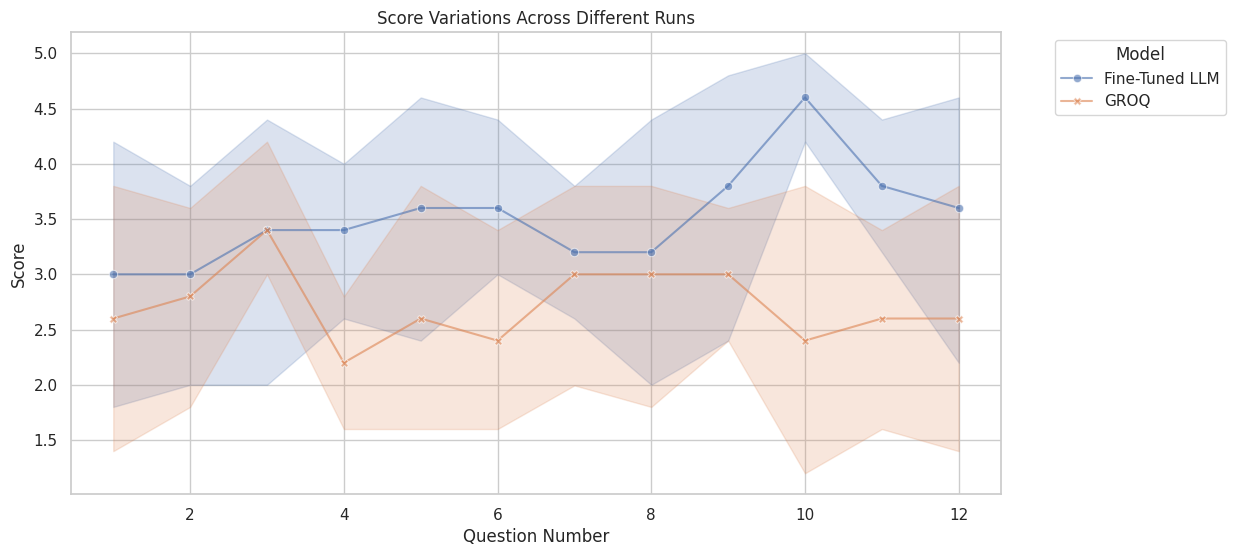

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Question Number', y='Score', hue='Model', style='Model', data=scores_variation_melted, markers=True, dashes=False, alpha=0.6)
plt.title('Score Variations Across Different Runs')
plt.xlabel('Question Number')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



### Line Plot Analysis (Score Variations Across Different Runs):

- **Fine-Tuned LLM:**
  - Generally more stable scores across runs.
  - Consistently higher scores in most questions.

- **GROQ:**
  - Greater score fluctuations.
  - Less consistent performance across runs.

### Summary:
- **Fine-Tuned LLM** is more stable and reliable.
- **GROQ** shows more variability and inconsistency.
